# Model interpretation (Estimators of the longitudinal frequencies)

In this notebook we will analyse the tuned HistGradientBoosting estimator to predict the frequency of the longitudinal mode. The residuals are calculated as the difference between the predicted and real frequencies. The SHAP tools helps us to better understand how the model predict the values.

In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import seaborn as sns
import shap
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from scipy.interpolate import griddata
from myfunctions import *
import pickle

## Load variables and target

In the first step we load the dataset, define the explanatory and target variables again:

In [5]:
# Load dataframes from binary files
fam = '03'
#base_dir = r'C:\FBr\Weiterbildung\Project'
base_dir = r'D:\Entwicklungen\share\DataScienceProject'

all_data = {}
fam_dir = os.path.join(base_dir, fam, 'data-' + fam)
all_data[fam] = {}

ft_param_path = os.path.join(base_dir, 'Scripts', 'ft_files', str(fam) + '-feat-parameters.ft')
ft_mode_path = os.path.join(base_dir, 'Scripts', 'ft_files', str(fam) + '-feat-modes.ft')
ft_nodes_path = os.path.join(base_dir, 'Scripts', 'ft_files', str(fam) + '-feat-nodes.ft')
ft_defs_path = os.path.join(base_dir, 'Scripts', 'ft_files', str(fam) + '-coll-defs.ft')

df_params = pd.read_feather(ft_param_path)
df_modes = pd.read_feather(ft_mode_path)
df_nodes = pd.read_feather(ft_nodes_path)
df_defs = pd.read_feather(ft_defs_path)

dump_dir = os.path.join(base_dir, 'Scripts', 'model_dumps')

In [6]:
lst_param = df_params.columns.to_list()

In [7]:
# Explanatory variables: all slot classes are considered, we add the 4 encoded columns to the selected dataset
lst_slot_class = lst_param[541:545]
lst_expl = lst_param[1:4] + lst_param[5:7] + lst_param[8:24] + lst_param[32:34]
# Target variable is the frequency of the longitudinal mode
target = 'freq_long'

X = df_params[lst_expl + lst_slot_class]
y = df_params[target]

In [8]:
# New Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

We reload the pipeline containing the preprocessing and the tuned regressor:

## LightGBM

In [9]:
pipe_tuned_lgbm = pickle.load(open(os.path.join(dump_dir, '4_model_lgbm_tuned_long_frequencies.pkl'), 'rb'))
print ('Score of the test set:', pipe_tuned_lgbm.score(X_test, y_test))

Score of the test set: 0.9933359528253154


## Analysis of the residuals

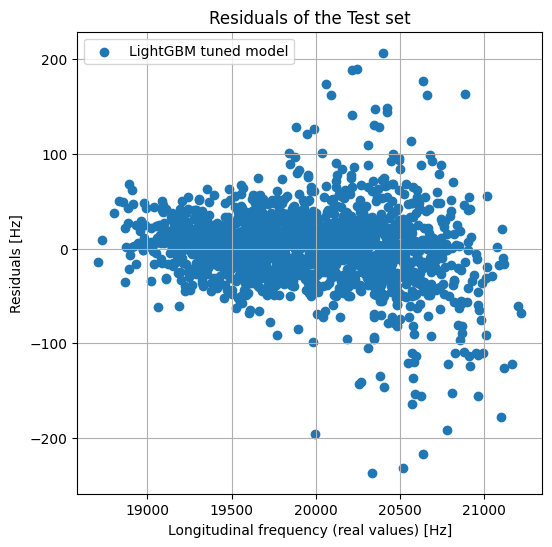

Maximum residual error: 236.83566663516467


In [10]:
y_pred_tuned_lgbm = pd.Series(pipe_tuned_lgbm.predict(X_test), index=y_test.index)
residuals_lgbm = y_pred_tuned_lgbm-y_test

fig = plt.figure(figsize=(6, 6))
plt.scatter(y_test, residuals_lgbm, label='LightGBM tuned model')
plt.xlabel('Longitudinal frequency (real values) [Hz]')
plt.ylabel('Residuals [Hz]')
plt.title('Residuals of the Test set')
plt.grid(True)
plt.legend()
plt.show()

print ('Maximum residual error:', np.abs(residuals_lgbm).max())

The residual distribution seems to be centered around 0. The Q-Q plot allows us the check the normality of the distribution by comparing the distribution of the actual data with a theoretical distribution (hier a standard normal law):

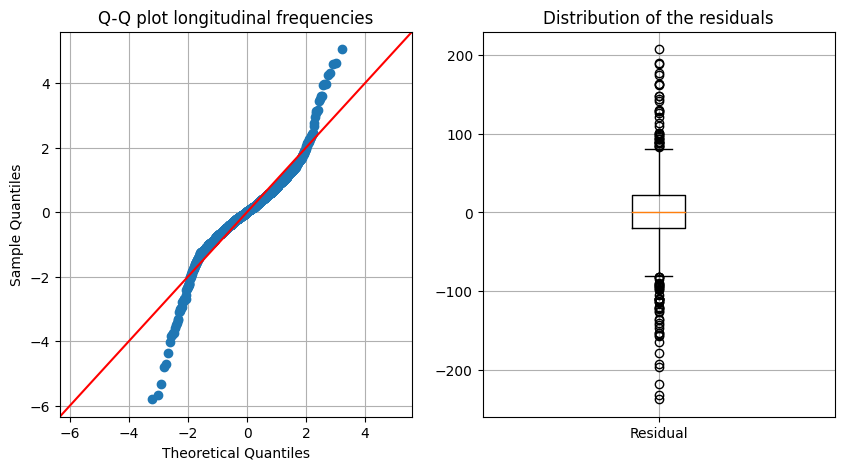

In [11]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 2, 1)
sm.qqplot(residuals_lgbm, fit=True, line='45', ax=ax)
plt.title ('Q-Q plot longitudinal frequencies')
plt.grid(True)
plt.plot

ax = fig.add_subplot(1, 2, 2)
plt.boxplot(residuals_lgbm)
plt.xticks([1], ['Residual'], rotation=0)
plt.xticks([1], ['Residual'], rotation=0)
plt.grid(True)

plt.title ('Distribution of the residuals')
plt.show()

* The residuals follow a normal law inside the first quantiles, the outliers are not normally distributed 
* There is no offset between the line and the points (mean of data is 0)
* The maximum absolute error is about 240 Hz

In [12]:
residuals_lgbm.describe()

count    1598.000000
mean        0.419433
std        40.921478
min      -236.835667
25%       -19.318926
50%         0.838696
75%        21.613173
max       206.856933
dtype: float64

## SHAP analysis

The model will be interpretated with SHAP to explain the output of the LightGBM estimator:

In [13]:
# Select 100 instances for use as the background distribution
X100 = shap.utils.sample(X, 100)  

# Calculate the SHAP values
explainer = shap.Explainer(pipe_tuned_lgbm.predict, X100)
shap_values = explainer(X100)

PermutationExplainer explainer: 101it [25:30, 15.30s/it]                         


The SHAP bar plot displays the mean absolute values of the Shapley values over all the observations. It creates a global measure of the feature importances. As already known the length of the sonotrode has the greatest influence on the longitudinal frequency. 

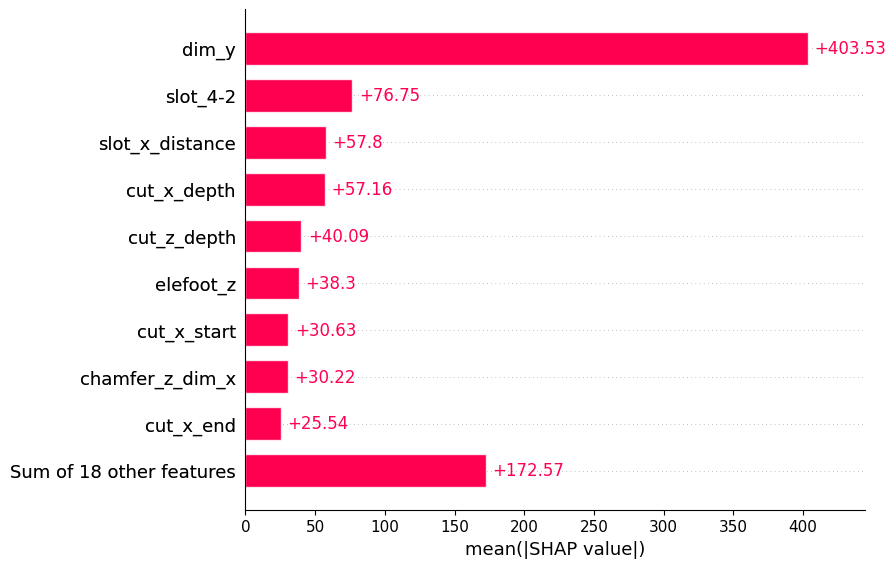

In [14]:
plt.figure(figsize=(4, 4))
shap.plots.bar(shap_values)

The beeswarm plot provides a visual summary of feature importance across multiple predictions. The vertical spread of the swarm at each feature represents the density of data points:

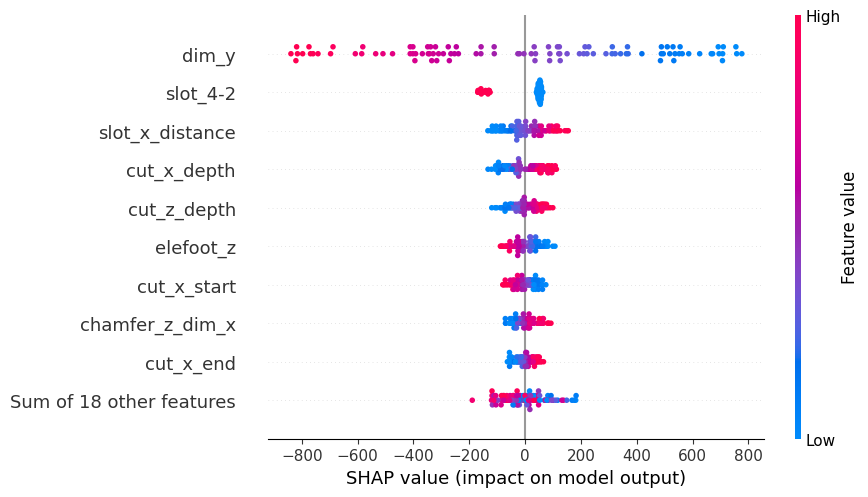

In [15]:
plt.figure(figsize=(4, 4))
shap.plots.beeswarm(shap_values)

* As the length (dim_y) value increases its SHAP value decreases (as expected)
* The second most important feature is the slot distribution class "4-2", whose values are 0 or 1. If the class is active, the longitudinal frequency is about 250 Hz lower. The effect is maximal for this slot distribution because of the number of slots is particulary important (6 slots).
* The chamfer widths and cut depths raise the frequencies since some mass is removed at the antinodes (points with maximum displacements).

## Best and worst predictions

Let's take a particular look into the best and worst predictions:

In [16]:
# Absolute value of the residuals
residuals_lgbm_abs = np.abs(residuals_lgbm)

In [17]:
idx_res_max = residuals_lgbm_abs.idxmax()
dp_no_res_max = df_params.loc[idx_res_max, 'dp_no']
print('Design point with the greatest residual:', dp_no_res_max, '(Error =', residuals_lgbm_abs.max(), 'Hz)')
print('Predicted frequency:', y_pred_tuned_lgbm[idx_res_max], 'Hz')
print('True frequency:', y_test[idx_res_max], 'Hz')

Design point with the greatest residual: 11429 (Error = 236.83566663516467 Hz)
Predicted frequency: 20094.074333364835 Hz
True frequency: 20330.91 Hz


In [18]:
idx_res_min = residuals_lgbm_abs.idxmin()
dp_no_res_min = df_params.loc[idx_res_min, 'dp_no']
print('Design point with the smallest residual:', dp_no_res_min, '(Error =', residuals_lgbm_abs.min(), 'Hz)')
print('Predicted frequency:', y_pred_tuned_lgbm[idx_res_min], 'Hz')
print('True frequency:', y_test[idx_res_min], 'Hz')

Design point with the smallest residual: 1189 (Error = 0.01716645763735869 Hz)
Predicted frequency: 19492.728833542362 Hz
True frequency: 19492.746 Hz


The design point 11429 is particularly interesting because the predicted frequency is close to the nominal frequency (20 kHz) and the real value is higher (20,3 kHz). Let's take a look at the modes that are in the vicinity of the longitudinal mode:

In [19]:
df_modes.loc[(df_modes['dp_no'] == dp_no_res_max) & ((df_modes['mode_no'] >= 54) & (df_modes['mode_no'] < 60)), ['dp_no', 'mode_no', 'freq', 'mode_mac']]

,dp_no,mode_no,freq,mode_mac
564025,11429,54,19321.948,0.000021
564026,11429,55,19993.723,0.284323
564027,11429,56,20109.459,0.000764
564028,11429,57,20330.910,0.374686
564029,11429,58,20736.378,0.000711
564030,11429,59,20895.412,0.000064


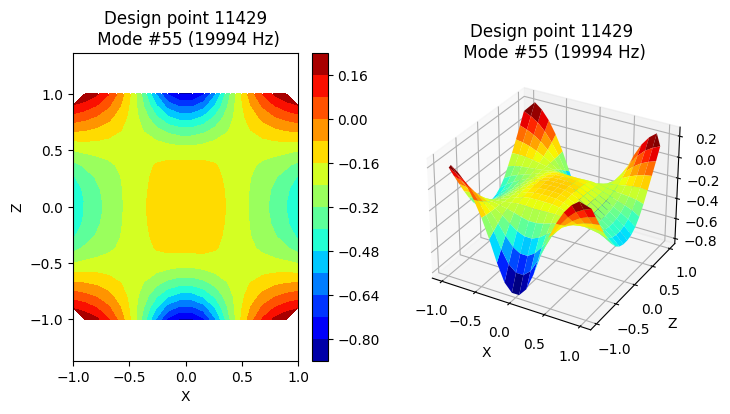

In [20]:
plot_2d_norm_disp(df_modes, df_nodes, df_defs, dp_no_res_max, 55, False);

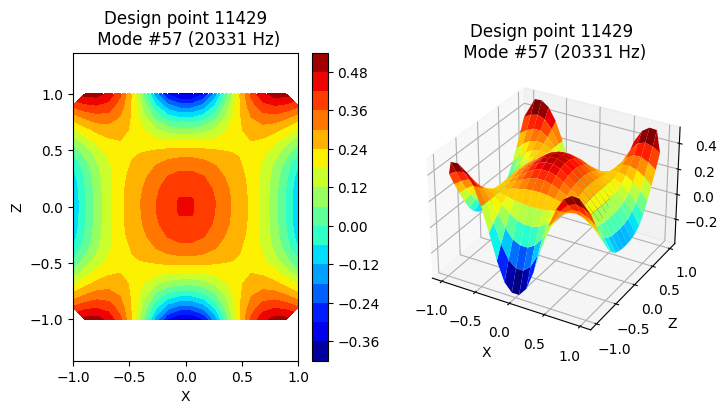

In [21]:
plot_2d_norm_disp(df_modes, df_nodes, df_defs, dp_no_res_max, 57, False);

With a look at the MAC values we can recognize that 2 modes are sharing the identification of the longitudinal mode. Even if the mode 57 has the greatest MAC value, the mode 55 located only 300 Hz below has an important longitudinal participation. In that specific case the longitudinal mode is not clearly identified and divided between 2 or more eigenvectors ("Degeneration" of the longitudinal mode). If the mode 55 has been picked as the longitudinal mode, then the residual would have been much lower.

Let's display the relationship between the residuals and the MAC values of the design points in the Test set

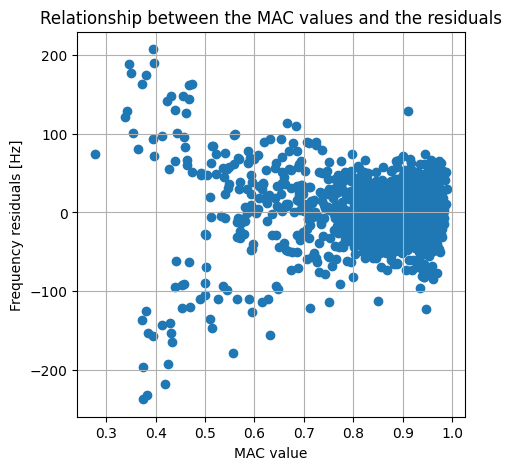

In [22]:
# Get the MAC values of the test set
idx_test = X_test.index
mac_long_test = df_params.loc[idx_test, 'mode_mac_long']

# The frequency residuals are plotted as a function of the MAC values
fig = plt.figure(figsize=(5, 5))
plt.scatter(mac_long_test, residuals_lgbm)
plt.xlabel('MAC value')
plt.ylabel('Frequency residuals [Hz]')
plt.title('Relationship between the MAC values and the residuals')
plt.grid(True)
plt.show()

### Filter the data according the MAC values

Why can the data be filtered? What does it mean from a practical point of view? Is this approach pertinent?

In [23]:
print('According the results of DP 11429, the residuals are increasing drastically for poor MAC values.')
print('By filtering out all design points with low MAC values, we focus on designs with clearly identified longitudinal modes and increase the quality of the predictions at the same time.')
print('If the threshold for MAC value is set at 0.75, ', len(df_params.loc[df_params['mode_mac_long'] > 0.75])/len(df_params)*100, '% of the data will be kept for the model.')

According the results of DP 11429, the residuals are increasing drastically for poor MAC values.
By filtering out all design points with low MAC values, we focus on designs with clearly identified longitudinal modes and increase the quality of the predictions at the same time.
If the threshold for MAC value is set at 0.75,  85.20650813516896 % of the data will be kept for the model.


In [24]:
# Filter the original DataFrame
df_params_filt = df_params.loc[df_params['mode_mac_long'] > 0.75]
df_params_filt.head()

,dp_no,dim_x,dim_y,dim_z,nb_slots_x,slot_x_length,slot_x_distance,nb_slots_z,slot_z_length,slot_z_distance,...,disp_long_396,disp_long_397,disp_long_398,disp_long_399,sum_sensi,coupling_long,slot_2-2,slot_3-2,slot_4-1,slot_4-2
0,1001,175.06,121.95,240.31,4,75.993,43.235,2,78.219,59.508,...,0.170716,0.140101,0.144549,0.151599,3.405414e-16,0.960466,0,0,0,1
1,1002,173.45,122.77,238.13,4,81.168,45.859,2,78.924,57.208,...,0.167263,0.146107,0.139493,0.143682,5.401730e-17,0.956635,0,0,0,1
2,1003,175.85,116.71,238.10,4,77.532,45.260,2,80.099,49.215,...,0.293034,0.274524,0.277739,0.284010,2.678586e-18,0.986845,0,0,0,1
3,1004,173.51,116.37,238.30,4,82.428,51.007,2,74.757,50.840,...,0.242726,0.182347,0.183003,0.186770,8.933099e-18,0.967459,0,0,0,1
4,1005,175.60,118.72,241.04,4,76.576,45.981,2,78.773,64.702,...,0.260120,0.259677,0.281911,0.293833,8.025438e-18,0.991598,0,0,0,1


In [25]:
X_filt = df_params_filt[lst_expl + lst_slot_class]
y_filt = df_params_filt[target]

# New Train-Test split
X_train_filt, X_test_filt, y_train_filt, y_test_filt = train_test_split(X_filt, y_filt, test_size=0.2, random_state=55)

We fit the estimator again with the same hyperparameters as before

In [26]:
pipe_lgbm_filt = pipe_tuned_lgbm
pipe_lgbm_filt.fit(X_train_filt, y_train_filt)
print ('Score of the new test set:', pipe_lgbm_filt.score(X_test_filt, y_test_filt))

[LightGBM] [Info] Total Bins 5858
[LightGBM] [Info] Number of data points in the train set: 5446, number of used features: 27
[LightGBM] [Info] Start training from score 19908.124241
Score of the new test set: 0.9970615545720903


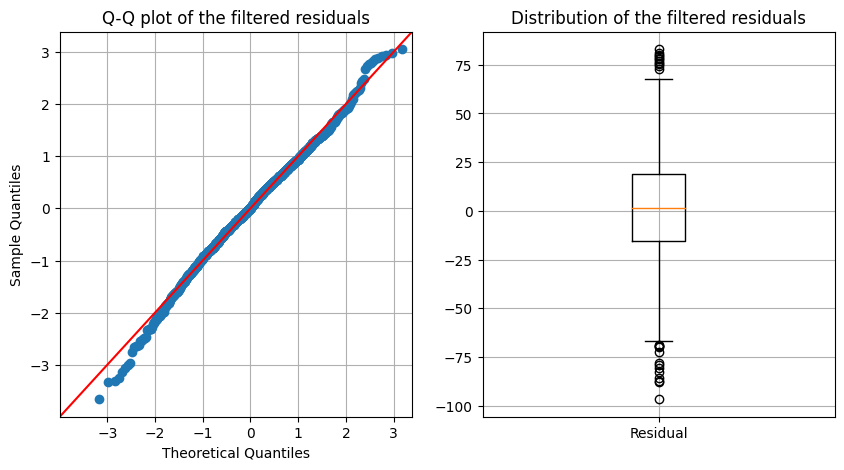

In [27]:
y_pred_lgbm_filt = pd.Series(pipe_lgbm_filt.predict(X_test_filt), index=y_test_filt.index)
residuals_lgbm_filt = y_pred_lgbm_filt-y_test_filt

# Q-Q plot of the new distribution
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
sm.qqplot(residuals_lgbm_filt, fit=True, line='45', ax=ax)
plt.grid(True)
plt.title('Q-Q plot of the filtered residuals')
plt.plot

ax = fig.add_subplot(1, 2, 2)
plt.boxplot(residuals_lgbm_filt)
plt.xticks([1], ['Residual'], rotation=0)
plt.title('Distribution of the filtered residuals')
plt.grid(True)

plt.show()

The distribution of the residuals with the filtered data set follows now a normal distribution and is still centered around 0. The mean absolute error (MAE) is the arithmetic average of the absolute errors (as it is scale-dependent accuracy measure, the unit is in Hz)

In [28]:
print ('Mean Absolute Error:', mean_absolute_error(y_test_filt, y_pred_lgbm_filt), 'Hz')

Mean Absolute Error: 21.09528895723602 Hz


The last step to confirm the presence of white noise is the test of autocorrelation. For this test, the residuals are analysed with the ACF (Autocorrelation Function):

<Figure size 400x400 with 0 Axes>

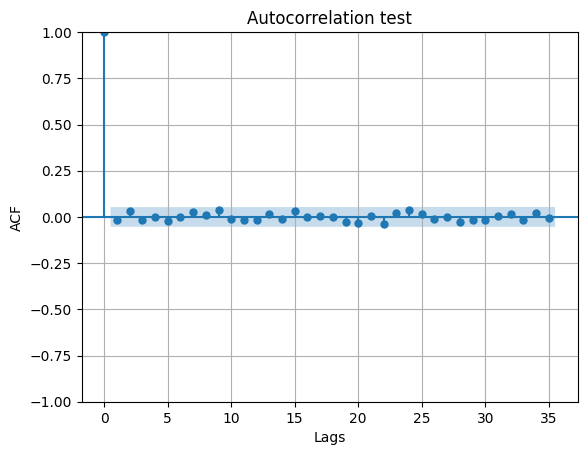

In [29]:
fig = plt.figure(figsize=(4, 4))
plot_acf(residuals_lgbm_filt.values, lags=35)
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.title('Autocorrelation test')
plt.grid(True)
plt.show()

All autocorrelation points are inside the confidence interval of 5%, the residuals can be considered as not autocorrelated. Therefore the white noise assumption is validated. 

In [30]:
# Dump the new model with filtered data
dump_dir = os.path.join(base_dir, 'Scripts', 'model_dumps')

pickle.dump(pipe_lgbm_filt, open(os.path.join(dump_dir, '6_model_lgbm_filt_long_frequencies.pkl'), 'wb'))